# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
# import time

# wait_to_make = "trained_list/google-electra-large-discriminator.txt"
# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    


In [2]:
EXP_NAME = "group"

In [3]:
# !nvidia-smi

In [4]:
! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime

INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
dt_now = datetime.datetime.now()

date = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
 
OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=2
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=3
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [8]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [9]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")


import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.6
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [12]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [13]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [14]:
train['group'] = train['context'] + " " + train['anchor']

allres = {}

for text in tqdm(train["group"].unique()):
  tmpdf = train[train["group"]==text].reset_index(drop=True)
  texts = ",".join(tmpdf["target"])
  allres[text] = texts

train["target_gp"] = train["group"].map(allres)

  0%|          | 0/1699 [00:00<?, ?it/s]

In [15]:
test['group'] = test['context'] + " " + test['anchor']

allres = {}

for text in tqdm(test["group"].unique()):
  tmpdf = test[test["group"]==text].reset_index(drop=True)
  texts = ",".join(tmpdf["target"])
  allres[text] = texts

test["target_gp"] = test["group"].map(allres)

  0%|          | 0/36 [00:00<?, ?it/s]

In [16]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']+pad+train["target_gp"]
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']+pad+test["target_gp"]
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,group,target_gp,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,group,target_gp,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,G02 opc drum,inorganic photoconductor drum,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,F23 adjust gas flow,altering gas flow,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,B60 lower trunnion,lower locating,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,D06 cap component,upper portion,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,H04 neural stimulation,artificial neural network,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

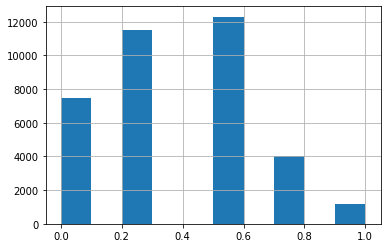

In [17]:
train['score'].hist()

In [18]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [19]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
encoder = LabelEncoder()
train['anchor_map'] = encoder.fit_transform(train['anchor'])

Fold = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'],groups=train["anchor_map"])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    12233
1    12111
2    12129
dtype: int64

In [20]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [21]:
# !pip install --no-cache-dir sentencepiece

In [22]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [23]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target', 'target_gp']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) +  max(lengths_dict['target_gp']) + 5 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 526


In [24]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [25]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [26]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [27]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [28]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [29]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/12120] Elapsed 0m 1s (remain 239m 13s) Loss: 0.6788(0.6788) Grad: inf  LR: 0.00002000  
Epoch: [1][100/12120] Elapsed 1m 1s (remain 122m 47s) Loss: 0.8400(0.6619) Grad: 91756.7422  LR: 0.00002000  
Epoch: [1][200/12120] Elapsed 2m 2s (remain 120m 55s) Loss: 0.6251(0.6653) Grad: 48602.2656  LR: 0.00002000  
Epoch: [1][300/12120] Elapsed 3m 2s (remain 119m 40s) Loss: 0.5690(0.6680) Grad: 119717.3984  LR: 0.00002000  
Epoch: [1][400/12120] Elapsed 4m 3s (remain 118m 32s) Loss: 0.5625(0.6669) Grad: 42002.8984  LR: 0.00002000  
Epoch: [1][500/12120] Elapsed 5m 4s (remain 117m 31s) Loss: 0.5856(0.6605) Grad: 22936.9141  LR: 0.00001999  
Epoch: [1][600/12120] Elapsed 6m 4s (remain 116m 27s) Loss: 0.7380(0.6578) Grad: 59942.5977  LR: 0.00001999  
Epoch: [1][700/12120] Elapsed 7m 5s (remain 115m 24s) Loss: 0.5745(0.6548) Grad: 27067.4941  LR: 0.00001999  
Epoch: [1][800/12120] Elapsed 8m 5s (remain 114m 19s) Loss: 0.6467(0.6573) Grad: 5554.6064  LR: 0.00001999  
Epoch: [1][900/1212

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/6117] Elapsed 0m 0s (remain 37m 12s) Loss: 0.8571(0.8571) 
EVAL: [100/6117] Elapsed 0m 20s (remain 20m 46s) Loss: 0.7268(0.6448) 
EVAL: [200/6117] Elapsed 0m 41s (remain 20m 21s) Loss: 0.6616(0.6460) 
EVAL: [300/6117] Elapsed 1m 2s (remain 19m 59s) Loss: 0.6616(0.6445) 
EVAL: [400/6117] Elapsed 1m 22s (remain 19m 38s) Loss: 0.6616(0.6474) 
EVAL: [500/6117] Elapsed 1m 43s (remain 19m 18s) Loss: 0.7920(0.6524) 
EVAL: [600/6117] Elapsed 2m 3s (remain 18m 57s) Loss: 0.7267(0.6519) 
EVAL: [700/6117] Elapsed 2m 24s (remain 18m 36s) Loss: 0.7269(0.6518) 
EVAL: [800/6117] Elapsed 2m 45s (remain 18m 16s) Loss: 0.7264(0.6523) 
EVAL: [900/6117] Elapsed 3m 5s (remain 17m 55s) Loss: 0.7260(0.6530) 
EVAL: [1000/6117] Elapsed 3m 26s (remain 17m 35s) Loss: 0.7268(0.6532) 
EVAL: [1100/6117] Elapsed 3m 47s (remain 17m 14s) Loss: 0.8568(0.6536) 
EVAL: [1200/6117] Elapsed 4m 7s (remain 16m 54s) Loss: 0.8577(0.6547) 
EVAL: [1300/6117] Elapsed 4m 28s (remain 16m 33s) Loss: 0.7265(0.6537) 
EVAL: [14

Epoch 1 - avg_train_loss: 0.6553  avg_val_loss: 0.6560  time: 8578s
Epoch 1 - Score: 0.0262
Epoch 1 - Save Best Score: 0.0262 Model


EVAL: [6116/6117] Elapsed 21m 1s (remain 0m 0s) Loss: 0.7268(0.6560) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/12120] Elapsed 0m 0s (remain 190m 44s) Loss: 0.6161(0.6161) Grad: inf  LR: 0.00001707  
Epoch: [2][100/12120] Elapsed 1m 0s (remain 120m 46s) Loss: 0.5999(0.6684) Grad: 25201.3809  LR: 0.00001702  
Epoch: [2][200/12120] Elapsed 2m 1s (remain 119m 44s) Loss: 0.6528(0.6678) Grad: 9048.7705  LR: 0.00001698  
Epoch: [2][300/12120] Elapsed 3m 1s (remain 118m 43s) Loss: 0.7860(0.6597) Grad: 41427.4102  LR: 0.00001693  
Epoch: [2][400/12120] Elapsed 4m 1s (remain 117m 43s) Loss: 0.6747(0.6572) Grad: 14188.6572  LR: 0.00001688  
Epoch: [2][500/12120] Elapsed 5m 1s (remain 116m 43s) Loss: 0.7982(0.6566) Grad: 62005.0273  LR: 0.00001684  
Epoch: [2][600/12120] Elapsed 6m 2s (remain 115m 42s) Loss: 0.5878(0.6551) Grad: 22590.0059  LR: 0.00001679  
Epoch: [2][700/12120] Elapsed 7m 2s (remain 114m 42s) Loss: 0.4569(0.6559) Grad: 43048.2461  LR: 0.00001674  
Epoch: [2][800/12120] Elapsed 8m 2s (remain 113m 42s) Loss: 0.7291(0.6566) Grad: 28356.6250  LR: 0.00001669  
Epoch: [2][900/12120

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/6117] Elapsed 0m 0s (remain 37m 0s) Loss: 0.9163(0.9163) 
EVAL: [100/6117] Elapsed 0m 20s (remain 20m 44s) Loss: 0.7484(0.6430) 
EVAL: [200/6117] Elapsed 0m 41s (remain 20m 19s) Loss: 0.6645(0.6445) 
EVAL: [300/6117] Elapsed 1m 1s (remain 19m 57s) Loss: 0.6646(0.6425) 
EVAL: [400/6117] Elapsed 1m 22s (remain 19m 37s) Loss: 0.6648(0.6464) 
EVAL: [500/6117] Elapsed 1m 43s (remain 19m 16s) Loss: 0.8322(0.6529) 
EVAL: [600/6117] Elapsed 2m 3s (remain 18m 55s) Loss: 0.7486(0.6521) 
EVAL: [700/6117] Elapsed 2m 24s (remain 18m 34s) Loss: 0.7483(0.6520) 
EVAL: [800/6117] Elapsed 2m 44s (remain 18m 14s) Loss: 0.7490(0.6526) 
EVAL: [900/6117] Elapsed 3m 5s (remain 17m 53s) Loss: 0.7497(0.6536) 
EVAL: [1000/6117] Elapsed 3m 26s (remain 17m 33s) Loss: 0.7484(0.6538) 
EVAL: [1100/6117] Elapsed 3m 46s (remain 17m 12s) Loss: 0.9168(0.6544) 
EVAL: [1200/6117] Elapsed 4m 7s (remain 16m 51s) Loss: 0.9154(0.6558) 
EVAL: [1300/6117] Elapsed 4m 27s (remain 16m 31s) Loss: 0.7489(0.6545) 
EVAL: [140

Epoch 2 - avg_train_loss: 0.6568  avg_val_loss: 0.6574  time: 8563s
Epoch 2 - Score: -0.0258


EVAL: [6116/6117] Elapsed 20m 59s (remain 0m 0s) Loss: 0.7483(0.6574) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/12120] Elapsed 0m 0s (remain 132m 38s) Loss: 0.5759(0.5759) Grad: 98385.8281  LR: 0.00001000  
Epoch: [3][100/12120] Elapsed 1m 0s (remain 120m 34s) Loss: 0.7618(0.6531) Grad: 71165.1797  LR: 0.00000993  
Epoch: [3][200/12120] Elapsed 2m 1s (remain 119m 45s) Loss: 0.9596(0.6500) Grad: 190087.0781  LR: 0.00000987  
Epoch: [3][300/12120] Elapsed 3m 1s (remain 118m 48s) Loss: 0.6035(0.6469) Grad: 61074.7891  LR: 0.00000980  
Epoch: [3][400/12120] Elapsed 4m 1s (remain 117m 50s) Loss: 0.5944(0.6480) Grad: 63998.1797  LR: 0.00000974  
Epoch: [3][500/12120] Elapsed 5m 2s (remain 116m 51s) Loss: 0.6019(0.6521) Grad: 73708.2422  LR: 0.00000968  
Epoch: [3][600/12120] Elapsed 6m 2s (remain 115m 51s) Loss: 0.7567(0.6517) Grad: 79184.6953  LR: 0.00000961  
Epoch: [3][700/12120] Elapsed 7m 3s (remain 114m 51s) Loss: 0.8406(0.6541) Grad: 144654.0625  LR: 0.00000955  
Epoch: [3][800/12120] Elapsed 8m 3s (remain 113m 51s) Loss: 0.9066(0.6530) Grad: 171963.8281  LR: 0.00000948  
Epoch: [3

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][12119/12120] Elapsed 122m 1s (remain 0m 0s) Loss: 0.5166(0.6557) Grad: 51010.2773  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/6117] Elapsed 0m 0s (remain 36m 47s) Loss: 0.8900(0.8900) 
EVAL: [100/6117] Elapsed 0m 20s (remain 20m 46s) Loss: 0.7385(0.6431) 
EVAL: [200/6117] Elapsed 0m 41s (remain 20m 21s) Loss: 0.6626(0.6445) 
EVAL: [300/6117] Elapsed 1m 2s (remain 19m 59s) Loss: 0.6626(0.6427) 
EVAL: [400/6117] Elapsed 1m 22s (remain 19m 38s) Loss: 0.6626(0.6462) 
EVAL: [500/6117] Elapsed 1m 43s (remain 19m 17s) Loss: 0.8143(0.6520) 
EVAL: [600/6117] Elapsed 2m 3s (remain 18m 57s) Loss: 0.7384(0.6514) 
EVAL: [700/6117] Elapsed 2m 24s (remain 18m 36s) Loss: 0.7385(0.6513) 
EVAL: [800/6117] Elapsed 2m 45s (remain 18m 15s) Loss: 0.7381(0.6518) 
EVAL: [900/6117] Elapsed 3m 5s (remain 17m 55s) Loss: 0.7378(0.6527) 
EVAL: [1000/6117] Elapsed 3m 26s (remain 17m 34s) Loss: 0.7384(0.6528) 
EVAL: [1100/6117] Elapsed 3m 46s (remain 17m 13s) Loss: 0.8898(0.6534) 
EVAL: [1200/6117] Elapsed 4m 7s (remain 16m 53s) Loss: 0.8905(0.6547) 
EVAL: [1300/6117] Elapsed 4m 28s (remain 16m 32s) Loss: 0.7382(0.6535) 
EVAL: [14

Epoch 3 - avg_train_loss: 0.6557  avg_val_loss: 0.6561  time: 8583s
Epoch 3 - Score: 0.0246


EVAL: [6116/6117] Elapsed 21m 0s (remain 0m 0s) Loss: 0.7385(0.6561) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/12120] Elapsed 0m 0s (remain 132m 51s) Loss: 0.6649(0.6649) Grad: 79988.7812  LR: 0.00000293  
Epoch: [4][100/12120] Elapsed 1m 0s (remain 120m 35s) Loss: 0.5946(0.6626) Grad: 61109.1992  LR: 0.00000288  
Epoch: [4][200/12120] Elapsed 2m 1s (remain 119m 46s) Loss: 0.6566(0.6445) Grad: 14677.9756  LR: 0.00000284  
Epoch: [4][300/12120] Elapsed 3m 1s (remain 118m 49s) Loss: 0.5798(0.6534) Grad: 38241.7930  LR: 0.00000279  
Epoch: [4][400/12120] Elapsed 4m 1s (remain 117m 50s) Loss: 0.7800(0.6576) Grad: 96760.1406  LR: 0.00000275  
Epoch: [4][500/12120] Elapsed 5m 2s (remain 116m 51s) Loss: 0.6648(0.6572) Grad: 19613.2480  LR: 0.00000270  
Epoch: [4][600/12120] Elapsed 6m 2s (remain 115m 52s) Loss: 0.6674(0.6563) Grad: 20506.3008  LR: 0.00000266  
Epoch: [4][700/12120] Elapsed 7m 3s (remain 114m 52s) Loss: 0.7017(0.6570) Grad: 51863.6836  LR: 0.00000262  
Epoch: [4][800/12120] Elapsed 8m 3s (remain 113m 52s) Loss: 0.6492(0.6562) Grad: 18172.5332  LR: 0.00000257  
Epoch: [4][9

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


KeyboardInterrupt: 

In [ ]:
print(f'{time.time()-start} hour')

In [ ]:
!touch trained_list/albert-base-v2.txt